In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 15:06:25 2023

@author: mariapopovic
"""


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile, assemble
import matplotlib.pyplot as plt
from numpy import array, arange, append
import math
#from qiskit.quantum_info import Statevector, partial_trace
from scipy.stats import norm



### Initialize distribution 

def __initialize_circuit__(a_bit,qc,register):
    
    index = 0
    for bit in a_bit:
        
        if bit == '1':
            qc.x(register[index])
        index = index + 1
    
    
    return qc


### Initialize coin

def __initialize_coin__(qc,register):    
    
    for qubit in register:
        qc.h(qubit)
    
    
    return qc


### Increment circuit

def increment(register):
    
    inc_qc = QuantumCircuit(register,name='Incr')
    
    for index in range(0, len(register)-1):

        controls = register[index + 1:]
        inc_qc.mcx(controls, register[index])
        
    inc_qc.x(register[-1])
    
    inc_qc = inc_qc.to_gate()
    
    return inc_qc

### Decrement circuit

def decrement(register):
    
    dec_qc = QuantumCircuit(register,name='Decr')
    
    for index in range(0, len(register)-1):

        controls = register[index + 1:]
        dec_qc.x(controls)
        dec_qc.mcx(controls, register[index])
        dec_qc.x(controls)
        
    dec_qc.x(register[-1])
    
    dec_qc = dec_qc.to_gate()
    
    return dec_qc

In [11]:
distribution_bits = 3 # From distribution_bits = 5, returns "Insufficient memory to run circuit" error
coin_bits = 2**(distribution_bits) + 2
initial_value = 0

# Create two's complements string for negative inputs
if initial_value < 0:
    binary = bin(-initial_value)[2:].zfill(distribution_bits)
    
    inverted_binary = ''
    for el in binary:
        if el == '0':
            inverted_binary = inverted_binary + '1'
        else: 
            inverted_binary = inverted_binary + '0'

    initial_state = bin(1 + int(inverted_binary, 2))[2:]
    
else:
    initial_state = bin(initial_value)[2:].zfill(distribution_bits)

distribution_register = QuantumRegister(distribution_bits,name='Distr')
coin_register = QuantumRegister(coin_bits,name='Coins')
classical_register = ClassicalRegister(distribution_bits)

circuit = QuantumCircuit(distribution_register,coin_register)

# Initialize the circuit
__initialize_circuit__(initial_state,circuit,distribution_register)

__initialize_coin__(circuit,coin_register)

control_increment = increment(distribution_register).control(1)

control_decrement = decrement(distribution_register).control(1)

# Circuit that includes negative numbers
coin_index = 0

while coin_index <= len(coin_register) - 1:
    

    circuit.append(control_decrement,[coin_register[coin_index],*distribution_register])
    circuit.append(control_increment,[coin_register[coin_index + 1],*distribution_register])
    
    coin_index = coin_index + 2

    
circuit.add_register(classical_register)
#circuit.save_statevector()
circuit.measure(distribution_register,classical_register)
print(circuit.draw())


simulator = Aer.get_backend('qasm_simulator')
results = execute(circuit, simulator, shots=5000).result()

#final_state = results.get_statevector()

counts = results.get_counts()

print(counts)




              ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
Distr_0: ─────┤0      ├┤0      ├┤0      ├┤0      ├┤0      ├┤0      ├┤0      ├»
              │       ││       ││       ││       ││       ││       ││       │»
Distr_1: ─────┤1 Decr ├┤1 Incr ├┤1 Decr ├┤1 Incr ├┤1 Decr ├┤1 Incr ├┤1 Decr ├»
              │       ││       ││       ││       ││       ││       ││       │»
Distr_2: ─────┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
         ┌───┐└───┬───┘└───┬───┘└───┬───┘└───┬───┘└───┬───┘└───┬───┘└───┬───┘»
Coins_0: ┤ H ├────■────────┼────────┼────────┼────────┼────────┼────────┼────»
         ├───┤             │        │        │        │        │        │    »
Coins_1: ┤ H ├─────────────■────────┼────────┼────────┼────────┼────────┼────»
         ├───┤                      │        │        │        │        │    »
Coins_2: ┤ H ├──────────────────────■────────┼────────┼────────┼────────┼────»
         ├───┤                               │      

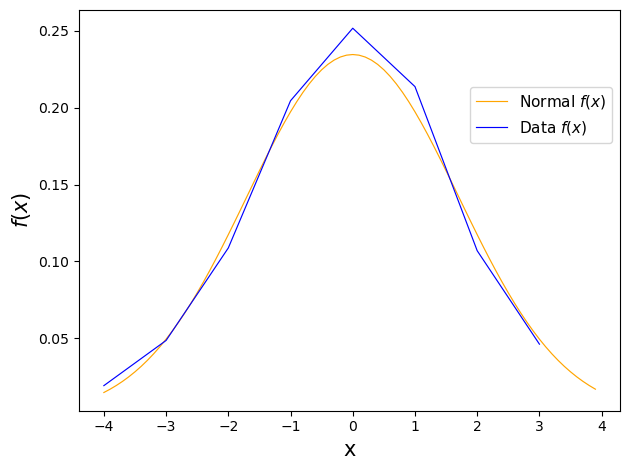

In [16]:
### Compare with normal probability distribution ###

# Convert quantum circuit output in arrays of counts and corresponding values

# Two's complement values
values = [x for x in range(-2**(distribution_bits - 1),2**(distribution_bits - 1))]

bits = []
frequency = []

normal_values = [x for x in range(0,2**(distribution_bits))]

#for el in values:
for el in normal_values:
     
    bits.append((bin(el)[2:].zfill(distribution_bits))[::-1])
    # Invert bit string, because of the bit inverse order in qiskit output

for el in bits:
    index = str(counts).find(str(el))
    # This is if one of the count numbers is the same as one of the binary strings
    # (ex: encounters 100 counts while it looks for the string '100'), to make sure it finds only the binary string
    if str(counts)[index - 2] == ":":
        tmp = str(counts)[:index - 4 - distribution_bits] + str(counts)[index + distribution_bits + 2:]
        index = tmp.find(str(el))
        index2 = index + 3 + distribution_bits
        count_value = ''
    
        while str(tmp)[index2] !="," and str(tmp)[index2] !="}":
            count_value = count_value + str(tmp)[index2]
            index2 = index2 + 1
    else:
        index2 = index + 3 + distribution_bits
        count_value = ''
    
        while str(counts)[index2] !="," and str(counts)[index2] !="}":
            count_value = count_value + str(counts)[index2]
            index2 = index2 + 1
        
    frequency.append(int(count_value))

data_pdf = [i * (1/sum(frequency)) for i in frequency]

# Reorganize data array according to two's complement notation
ordered_data = append(data_pdf[2**(distribution_bits - 1):],data_pdf[:2**(distribution_bits - 1)])


# Plot normal pdf and compare with the algorithm output


mean = initial_value
variance = 1.7
step = 0.1
x = arange(-2**(distribution_bits - 1),2**(distribution_bits - 1),step)
normal_distribution = []


for el in x:
    normal_distribution.append(norm.pdf(el,loc = mean, scale=variance))

f = plt.figure(1)
ax = plt.axes()

ax.plot(x,normal_distribution,label=r'Normal $f(x)$', linewidth = 0.85, color = 'orange')
ax.plot(values,ordered_data,label=r'Data $f(x)$', linewidth = 0.85, color = 'blue')

ax.set_xlabel('x',fontsize=15)
ax.set_ylabel(r'$f(x)$',fontsize=15)

plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.65),fontsize=11)


plt.show()
